In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import csv

with open('chembl_thrombin_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    thrombin_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [20:39:13] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [20:39:13] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [20:39:13] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [20:39:13] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [20:39:13] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [20:39:14] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [20:39:14] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [20:39:14] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [20:39:14] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [20:39:14] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [20:39:14] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [20:39:14] Can't kek

In [2]:
def too_many_hbd(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 5

def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 10

def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 500

def too_greasy(mol):
    return Descriptors.MolLogP(mol) > 5

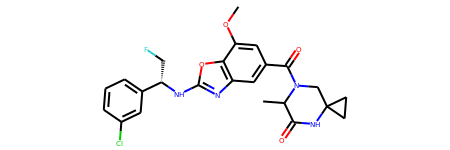

In [3]:
thrombin_ligands[3141]

In [4]:
too_many_hbd(thrombin_ligands[3141]), too_many_hba(thrombin_ligands[3141]), \
too_heavy(thrombin_ligands[3141]), too_greasy(thrombin_ligands[3141])

(False, False, False, False)

Tenhle uličník vypadá ok. Napočítal jsem 6 HBA, 2 HBD, Mw 487 je skoro na hraně a logP jsem si napočítal na 2,35.

In [5]:
thrombin_ligands_too_many_hbd = [too_many_hbd(l) for l in thrombin_ligands]
thrombin_ligands_too_many_hba = [too_many_hba(l) for l in thrombin_ligands]
thrombin_ligands_too_heavy = [too_heavy(l) for l in thrombin_ligands]
thrombin_ligands_too_greasy = [too_greasy(l) for l in thrombin_ligands]
sum(thrombin_ligands_too_many_hbd), sum(thrombin_ligands_too_many_hba), \
sum(thrombin_ligands_too_heavy), sum(thrombin_ligands_too_greasy), len(thrombin_ligands)

(1130, 1007, 1556, 265, 3236)

Tedy, nic extra. Třetina látek nesplňuje požadavky na HBD, HBA, nebo na svou velikost. Lepší výsledek se týká logP, kde se jedná o něco pod desetinu látek. Co se týče drug-likeness, tento set se mi nejeví úplně vhodný tedy. :(

In [6]:
import pandas as pd
df = pd.DataFrame(data={'set':'thrombin',
                        'too_many_hbd': thrombin_ligands_too_many_hbd,
                        'too_many_hba': thrombin_ligands_too_many_hba,
                        'too_greasy': thrombin_ligands_too_greasy,
                        'too_heavy': thrombin_ligands_too_heavy})
df

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy
0,thrombin,True,True,False,True
1,thrombin,False,False,True,True
2,thrombin,False,False,False,False
3,thrombin,False,False,False,True
4,thrombin,False,False,False,False
...,...,...,...,...,...
3231,thrombin,True,True,False,True
3232,thrombin,False,True,False,True
3233,thrombin,False,True,False,True
3234,thrombin,False,True,False,True


In [7]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 11.7)})
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")

In [8]:
def ro5_violations(mol):
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    return ro5_violations(mol) > 1

In [9]:
thrombin_ro5_violations = [ro5_violations(l) for l in thrombin_ligands]
thrombin_violates_lipinski = [violates_lipinski(l) for l in thrombin_ligands]
sum(thrombin_ro5_violations),\
sum(thrombin_ro5_violations)/len(thrombin_ro5_violations),\
sum(thrombin_violates_lipinski),\
sum(thrombin_violates_lipinski)/len(thrombin_violates_lipinski)

(3958, 1.223114956736712, 1275, 0.39400494437577255)

3958 porušení RO5 v setu, tedy 1.22 na molekulu. Cca třetina pak porušuje víc, než jedno provadilo.

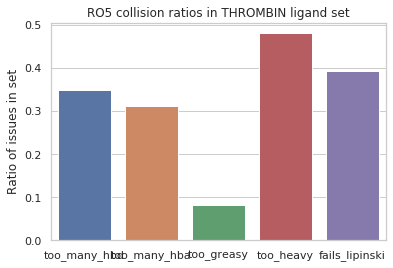

In [10]:
df['fails_lipinski'] = thrombin_violates_lipinski
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")

Úspěšně jsem vygeneroval sloupce neúspěchu.

In [11]:
from rdkit.Chem import Crippen

def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

df['odd_greasyness'] = [bad_greasyness_ghose(l) for l in thrombin_ligands]

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
df['odd_refractivity'] = [bad_refractivity_ghose(l) for l in thrombin_ligands]

def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
df['odd_mass'] = [bad_mw_ghose(l) for l in thrombin_ligands]

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
df['odd_atomcount'] = [bad_atomcount_ghose(l) for l in thrombin_ligands]

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
df['fails_ghose'] = [violates_ghose(l) for l in thrombin_ligands]

def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
df['too_rotatable'] = [too_rotatable_veber(l) for l in thrombin_ligands]

def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
df['excessive_psa'] = [too_large_psa_veber(l) for l in thrombin_ligands]

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
df['fails_veber'] = [violates_veber(l) for l in thrombin_ligands]

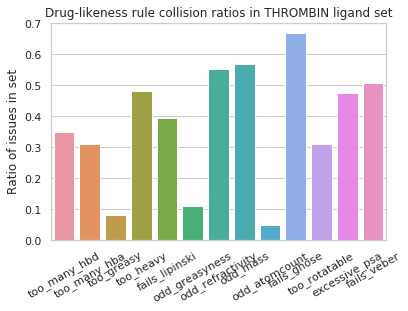

In [12]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("Drug-likeness rule collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30)

To skoro vypadá, jako kdyby v Ghose_filtru téměř 3/4 látek propadly. Téměř polovina látek je příliš velká (tady mě opět napadá případ peptidů, kdy se oligopeptidy - ale třeba i oligonukleotidy atd. - používají k léčbě řady nemocí - ale chápu, že tady jsme spíš v říši malých molekul).

Obecně vzato - a už jsem to psal výše - si myslím, že můj set ligandů není úplně ideální výběr potenciálních léčiv. Vlastně si říkám, že bylo docela štěstí, že jsem na začátku vybral látku, která splňovala všechno.

In [13]:
df_drugbank = pd.DataFrame(
    data={'set':'DrugBank',
          'too_many_hbd': [too_many_hbd(l) for l in drugs],
          'too_many_hba': [too_many_hba(l) for l in drugs],
          'too_greasy': [too_greasy(l) for l in drugs],
          'too_heavy': [too_heavy(l) for l in drugs],
          'fails_lipinski': [violates_lipinski(l) for l in drugs],
          'odd_greasyness': [bad_greasyness_ghose(l) for l in drugs],
          'odd_refractivity': [bad_refractivity_ghose(l) for l in drugs],
          'odd_mass': [bad_mw_ghose(l) for l in drugs],
          'odd_atomcount': [bad_atomcount_ghose(l) for l in drugs],
          'fails_ghose': [violates_ghose(l) for l in drugs],
          'too_rotatable': [too_rotatable_veber(l) for l in drugs],
          'excessive_psa': [too_large_psa_veber(l) for l in drugs],
          'fails_veber': [violates_veber(l) for l in drugs]})
df_drugbank

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy,fails_lipinski,odd_greasyness,odd_refractivity,odd_mass,odd_atomcount,fails_ghose,too_rotatable,excessive_psa,fails_veber
0,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
1,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
2,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
3,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
4,DrugBank,False,True,False,True,True,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,DrugBank,False,False,False,False,False,False,True,True,True,True,False,False,False
7109,DrugBank,False,False,False,False,False,True,False,False,False,True,False,True,True
7110,DrugBank,True,True,False,True,True,False,True,True,True,True,True,True,True
7111,DrugBank,False,False,False,False,False,False,False,False,False,False,True,False,True


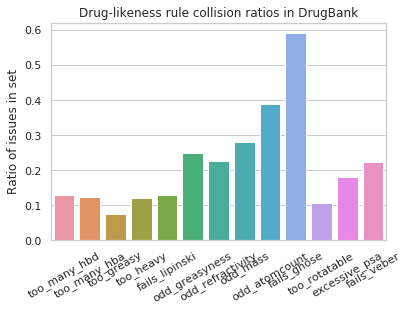

In [14]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_drugbank, ci=None)
    p.set_title("Drug-likeness rule collision ratios in DrugBank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30)

Ghose filter nesplňuje něco přes polovinu látek (pořád lepší, než thrombinový set). Zato Lipinského nesplňuje asi desetina, což je lepší než 40 % u thrombinu. Docela mě překvapuje, že tato čísla jsou u DRUGBANKY tak vysoká. Ale jak píšete - není to Korán. :)

Následuje pokus o mou vlastní invenci:

In [15]:
def too_many_hbd(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 3

def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 3

def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 300

def too_greasy(mol):
    return Descriptors.MolLogP(mol) > 3

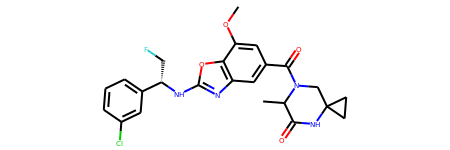

In [16]:
thrombin_ligands[3141]

In [17]:
too_many_hbd(thrombin_ligands[3141]), too_many_hba(thrombin_ligands[3141]), \
too_heavy(thrombin_ligands[3141]), too_greasy(thrombin_ligands[3141])

(False, True, True, True)

Uličník splňuje jen HBD, které jsem napočítal 2. Zkusme jinou:

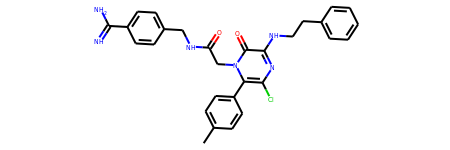

In [18]:
thrombin_ligands[1985]

In [19]:
too_many_hbd(thrombin_ligands[1985]), too_many_hba(thrombin_ligands[1985]), \
too_heavy(thrombin_ligands[1985]), too_greasy(thrombin_ligands[1985])

(True, True, True, True)

Ani jeden...

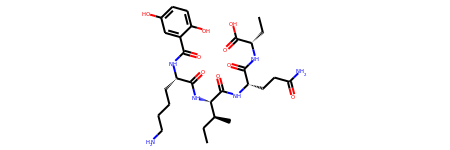

In [20]:
thrombin_ligands[863]

In [21]:
too_many_hbd(thrombin_ligands[863]), too_many_hba(thrombin_ligands[863]), \
too_heavy(thrombin_ligands[863]), too_greasy(thrombin_ligands[863])

(True, True, True, False)

Ani rok příchodu slovanských věrozvěstů nezabral...

In [22]:
thrombin_ligands_too_many_hbd = [too_many_hbd(l) for l in thrombin_ligands]
thrombin_ligands_too_many_hba = [too_many_hba(l) for l in thrombin_ligands]
thrombin_ligands_too_heavy = [too_heavy(l) for l in thrombin_ligands]
thrombin_ligands_too_greasy = [too_greasy(l) for l in thrombin_ligands]
sum(thrombin_ligands_too_many_hbd), sum(thrombin_ligands_too_many_hba), \
sum(thrombin_ligands_too_heavy), sum(thrombin_ligands_too_greasy), len(thrombin_ligands)

(2023, 3160, 3018, 1401, 3236)

Dvě třetiny molekul mají moc HBD, téměř všechny nesplňují požadavky na HBA a Mw. Necelá polovina nesplňuje logP.

In [23]:
import pandas as pd
df = pd.DataFrame(data={'set':'thrombin',
                        'too_many_hbd': thrombin_ligands_too_many_hbd,
                        'too_many_hba': thrombin_ligands_too_many_hba,
                        'too_greasy': thrombin_ligands_too_greasy,
                        'too_heavy': thrombin_ligands_too_heavy})
df

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy
0,thrombin,True,True,False,True
1,thrombin,True,True,True,True
2,thrombin,True,True,False,True
3,thrombin,True,True,True,True
4,thrombin,True,True,True,True
...,...,...,...,...,...
3231,thrombin,True,True,False,True
3232,thrombin,False,True,False,True
3233,thrombin,False,True,False,True
3234,thrombin,False,True,False,True


Touto tabulkou bych si rád proscrolloval, ale nevím jak. :-/

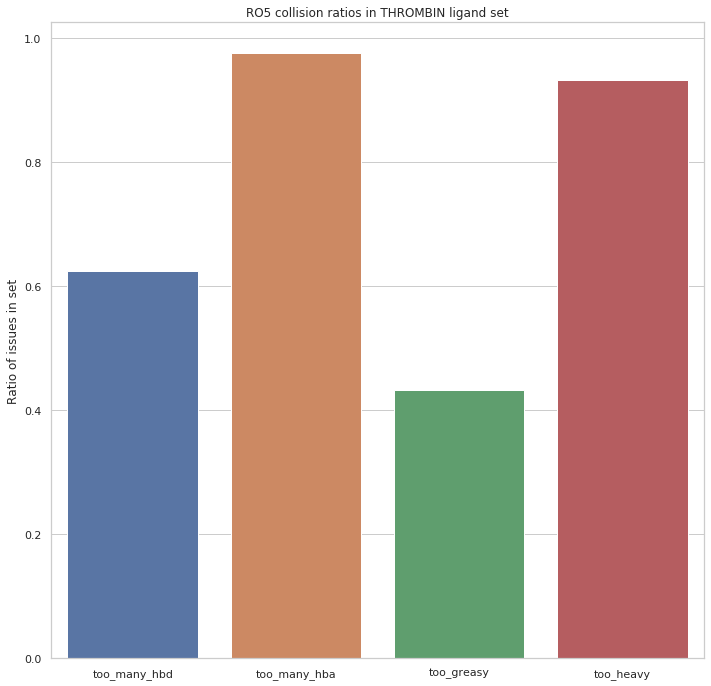

In [24]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 11.7)})
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")

Přes 60 % látek má moc HBD, skoro všechny moc HBA. O trochu pozitivnější je to u logP, nicméně u hmotnosti se opět dostáváme do depresivních hodnot.

In [35]:
def ro5_violations(mol):
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    return ro5_violations(mol) > 2

In [36]:
thrombin_ro5_violations = [ro5_violations(l) for l in thrombin_ligands]
thrombin_violates_lipinski = [violates_lipinski(l) for l in thrombin_ligands]
sum(thrombin_ro5_violations),\
sum(thrombin_ro5_violations)/len(thrombin_ro5_violations),\
sum(thrombin_violates_lipinski),\
sum(thrombin_violates_lipinski)/len(thrombin_violates_lipinski)

(9602, 2.9672435105067985, 2606, 0.8053152039555006)

Téměř 10 tisíc porušení RO5, tedy necelé 3 na molekulu. 2606 molekul porušuje víc jak dvě. Tedy víc jak 3/4.

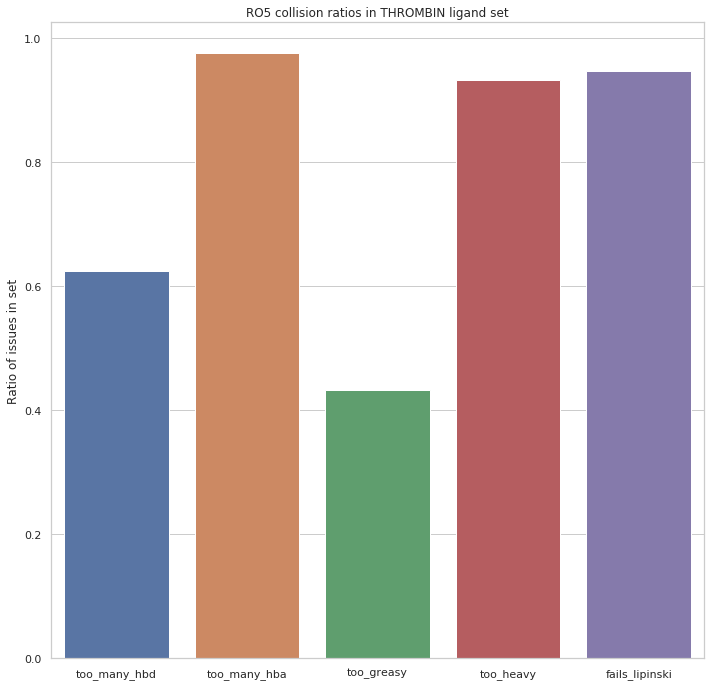

In [27]:
df['fails_lipinski'] = thrombin_violates_lipinski
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")

In [28]:
from rdkit.Chem import Crippen

def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

df['odd_greasyness'] = [bad_greasyness_ghose(l) for l in thrombin_ligands]

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
df['odd_refractivity'] = [bad_refractivity_ghose(l) for l in thrombin_ligands]

def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
df['odd_mass'] = [bad_mw_ghose(l) for l in thrombin_ligands]

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
df['odd_atomcount'] = [bad_atomcount_ghose(l) for l in thrombin_ligands]

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
df['fails_ghose'] = [violates_ghose(l) for l in thrombin_ligands]

def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
df['too_rotatable'] = [too_rotatable_veber(l) for l in thrombin_ligands]

def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
df['excessive_psa'] = [too_large_psa_veber(l) for l in thrombin_ligands]

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
df['fails_veber'] = [violates_veber(l) for l in thrombin_ligands]

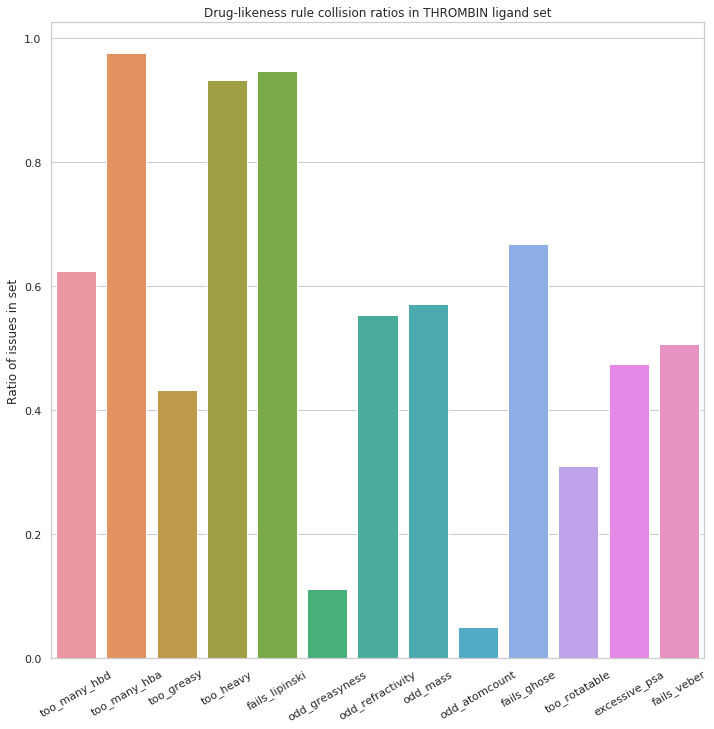

In [30]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("Drug-likeness rule collision ratios in THROMBIN ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30)

Pravidlo na HBA a hmotu porušují skoro všechny. Zajímavější mi přijde, že Ghose nyní porušuje méně látek, než předtím. To nedovedu vysvětlit. :(